# Advanced Lanes Finding Project

In [1]:
# importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual

%matplotlib inline

In [2]:
def _build_full_paths(dir_root):
    return [dir_root+'/'+fn for fn in os.listdir(dir_root)]

class CameraCalibrator:
    def __init__(self, nx=9, ny=6):
        self.nx = nx
        self.ny = ny
        self.mtx = None
        self.dist = None
        
    def _find_corners(self, filenames, show_images=False):
        objpoints, imgpoints = [], [] # 3d points in real world space, # 2d points in image plane.
    
        # Prepare obj points
        objp = np.zeros((self.nx * self.ny, 3), np.float32)
        objp[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1,2)
        
        img_size = None
    
        for fn in filenames:
            #reading in an image
            image = mpimg.imread(fn)
            gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)
        
            if img_size is None:
                img_size = (image.shape[1], image.shape[0])
        
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                
                if show_images:
                    image = cv2.drawChessboardCorners(image, (self.nx, self.ny), corners, ret)
                    plt.imshow(image)
                    plt.figure()
    
        return objpoints, imgpoints, img_size
    
    def _calibrate_camera(self, objpoints, imgpoints, img_size):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        return mtx, dist
    
    def calibrate(self, filenames):
        objpoints, imgpoints, img_size = self._find_corners( filenames, show_images=False )
        self.mtx, self.dist = self._calibrate_camera(objpoints, imgpoints, img_size)
        return self.mtx, self.dist
       
        
ccal1 = CameraCalibrator()
ccal1.calibrate( _build_full_paths('camera_cal/') );

In [3]:
class Undistorter:
    def __init__(self, camera_calibrator):
        self.camera_calibrator = camera_calibrator
        
    def undistort_image(self, img):
        mtx, dist = self.camera_calibrator.mtx, self.camera_calibrator.dist
        return cv2.undistort(img, mtx, dist, None, mtx)
        
    def read_undistort_images(self, filenames):
        undistorted_imgs = []
    
        for fn in filenames:
            img = mpimg.imread(fn)
        
            undst = self.undistort_image(img)
            undistorted_imgs.append( (img, undst, ) )
        
        return undistorted_imgs
        
undistorter = Undistorter(ccal1)

In [4]:
class PerspectiveWarper:
    def __init__(self):
        self.M = None
        self.Minv = None
        
    def _perspective(self, matrix, img):  
        if matrix is None:
            raise ValueError("!!! The matrix M must be computed by method compute_perspective_transform() before calling warp_perspective()")
            
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, matrix, img_size)
    
    def compute_perspective_transform(self, src, dst):
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
    
    def warp_perspective(self, img):
        return self._perspective(self.M, img)
    
    def unwarp_perspective(self, img):
        return self._perspective(self.Minv, img)

In [5]:
persp_warper = PerspectiveWarper()

# Compute the perspective matrix for the road:
def compute_road_perspective_matrix(perspective_warper):
    # src = np.float32([[535, 460], [750, 460], [1480, 720], [-180, 720]])
    src = np.float32([[535, 460], [750, 460], [1480, 720], [-180, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    
    perspective_warper.compute_perspective_transform(src, dst)

compute_road_perspective_matrix(persp_warper)

In [6]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def filter_white_yellow(img):
    def mask(hsv, hsv_lower, hsv_upper):
        return cv2.inRange(hsv, np.array(hsv_lower, dtype=np.uint8), np.array(hsv_upper, dtype=np.uint8))
        
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    mask_yellow = mask(hsv, [20,100,100], [52,255,255])
    sensitivity = 50
    mask_white = mask(hsv, [0,0,255-sensitivity], [255, sensitivity, 255])
    mask = cv2.bitwise_or(mask_white, mask_yellow)
        
    return cv2.bitwise_and(img, img, mask=mask)


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def perspective(img):
    height, width, ch = img.shape
    half_height = 0.6*height
    vertices = np.array([[(0,height),(0.43*width, half_height), (0.58*width, half_height), (width,height)]], dtype=np.int32)
    return region_of_interest(img, vertices)


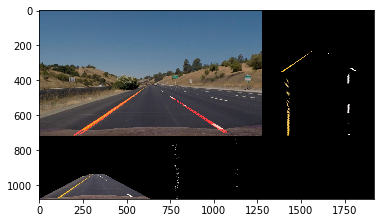

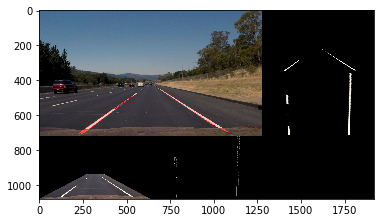

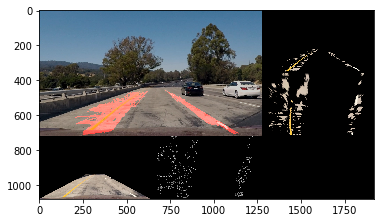

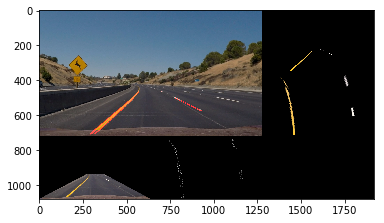

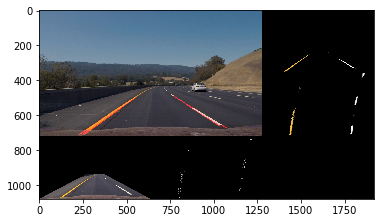

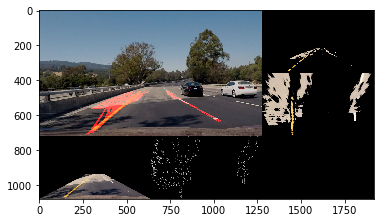

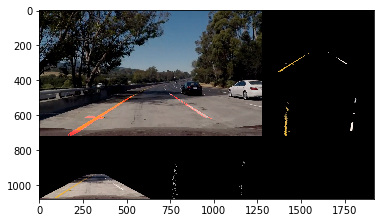

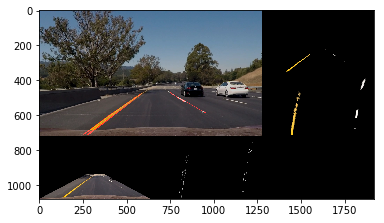

In [12]:
from moviepy.editor import VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

from IPython.display import HTML

def process_image(img, debug=True):
    undist = undistorter.undistort_image(img)
    perspect = perspective(undist)
    filtered = filter_white_yellow(perspect)
    warped = persp_warper.warp_perspective(filtered)
    
    gray = grayscale(warped)
    blur = gaussian_blur(gray, 3) 
    can = canny(blur, 130, 150)
    
    edges = hough_lines(can, 1, np.pi/180., 30, 100, 160)
    edges = persp_warper.unwarp_perspective(edges)
    
    if debug:
        shape = img.shape
        new_shape = (int(shape[0] * 1.5), int(shape[1] * 1.5), 3)
        dimg = np.zeros(new_shape, dtype=img.dtype)
    
        dimg[:shape[0], :shape[1]] = weighted_img(edges, img)
        half_shape = (shape[0] // 2, shape[1] // 2)
    
        offset = shape[1]
    
        # Display top right side image
        dimg[:shape[0]//2, offset:offset+shape[1]//2,:] = cv2.resize(filtered, half_shape[::-1])
        
        # Display bottom right side image
        dimg[shape[0]//2:shape[0], offset:offset+shape[1]//2,:] = cv2.resize(warped, half_shape[::-1])
        #dimg[shape[0]//2:shape[0], offset:offset+shape[1]//2,0] = side_img
        #dimg[shape[0]//2:shape[0], offset:offset+shape[1]//2,1] = side_img
        #dimg[shape[0]//2:shape[0], offset:offset+shape[1]//2,2] = side_img
    
        # Display bottom right image
        dimg[shape[0]:, :shape[1]//2,:] = cv2.resize(perspect, half_shape[::-1])
    
        # Display bottom center image
        bottom_img = cv2.resize(can, half_shape[::-1])
        dimg[shape[0]:, shape[1]//2:shape[1],0] = bottom_img
        dimg[shape[0]:, shape[1]//2:shape[1],1] = bottom_img
        dimg[shape[0]:, shape[1]//2:shape[1],2] = bottom_img
        
        return dimg
    else:
        return img

for fn in _build_full_paths("test_images/"):
    img = mpimg.imread(fn)
    plt.imshow(process_image(img))
    plt.figure()

In [13]:
project_output = 'project_test.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) 

%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_test.mp4
[MoviePy] Writing video project_test.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:06<00:00, 18.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_test.mp4 

Wall time: 1min 6s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video.mp4"))